In [1]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import scipy

import sys
sys.path.append("src")

import last_year
from music import *

In [2]:
# fs, data = wavfile.read('last_year/fq_sample3_spkr0_angle20.wav')
fs, data = wavfile.read("res/arctic_a0010.wav")
data_variance = np.var(data)
IPython.display.Audio((data / max(data)) + np.random.normal(scale=0.1, size=len(data)), rate=fs)

In [3]:
data_variance

16844305.134976026

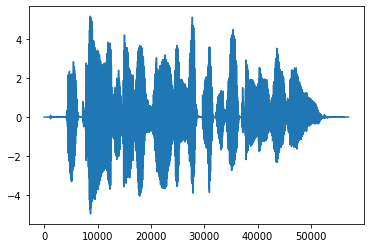

In [4]:
plt.plot(data / np.std(data))

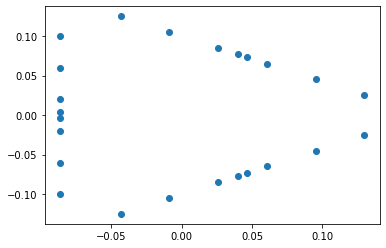

In [5]:
import json

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

# microphone_2D_locations = np.array([np.array([0.04 * i, 0]) for i in range(16)])

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.show()

In [6]:
c = 343.    # speed of sound
start = 4
n_mics = len(microphone_2D_locations)

distance = 6.  # meters
sigma2 = 0.0 * data_variance

(<Figure size 432x288 with 1 Axes>, <Axes: >)

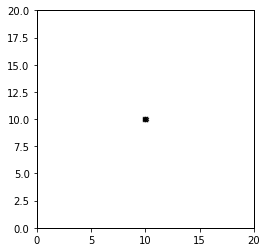

In [7]:
room_dim = np.r_[20.,20.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

aroom.plot()

(<Figure size 432x288 with 1 Axes>, <Axes: >)

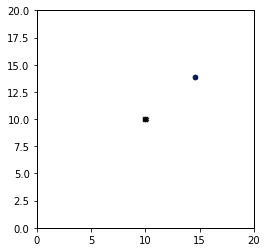

In [8]:
# Add sources of 1 second duration
azimuth = np.array([40]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

w_correlated = np.array([1/4, 1/4]) * np.pi



for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]    

    aroom.add_source(source_location, signal=data)

# Run the simulation
aroom.simulate()
aroom.plot()

In [9]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

In [10]:
samples = aroom.mic_array.signals
((samples.T - np.mean(samples, axis=1).T) / np.std(samples, axis=1).T).T.shape

(24, 57406)

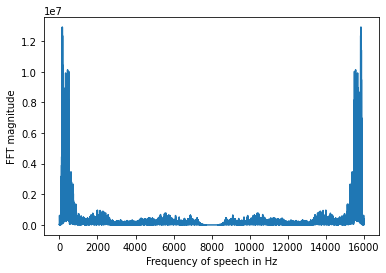

In [11]:
fft = np.fft.fft(data)
frequencies = np.linspace(0, fs, len(fft))

selected_ids = np.argwhere(frequencies < 100000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.show()

## Benchmarks

Samples shape: (24, 57406)
Covariance shape: (24, 24)
Extracted frequencies in degrees: [221.328]


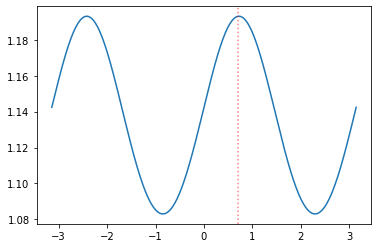

In [12]:
n_sources = len(azimuth)

spectrum = music(aroom.mic_array.signals, n_sources, mics_coords, 125, correlated=False)
X = np.linspace(-np.pi, np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi]) * 180 / np.pi)
plt.show()

Samples shape: (24, 57406)
Covariance shape: (24, 24)
Extracted frequencies in degrees: [219.852]


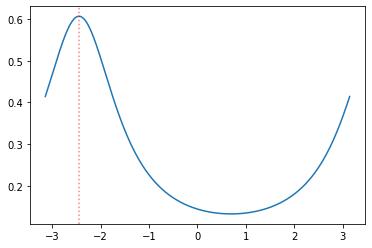

In [22]:
from scipy.signal import hilbert

n_sources = len(azimuth)

spectrum = music(hilbert(aroom.mic_array.signals), n_sources, mics_coords, 125, correlated=False)
X = np.linspace(-np.pi, np.pi, 1000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta - np.pi, color='red', linestyle=':', alpha=0.5)

print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi]) * 180 / np.pi)
plt.show()

Shape of sources STFT: (251, 9, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 23)
Extracted frequencies in degrees: [39.924]


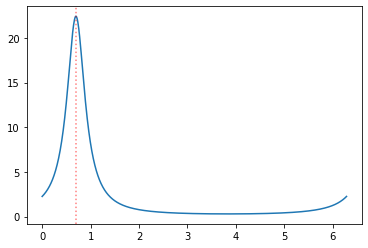

In [20]:
n_sources = len(azimuth)
seg_duration = 1
freq_range=[0, 250]

spectrum = music_with_frequency(aroom.mic_array.signals, n_sources, fs, mics_coords, segment_duration=seg_duration, freq_range=freq_range,
                                correlated=False)

X = np.linspace(0, 2 * np.pi, 1000)
Y = np.array([spectrum(x) for x in X])

plt.plot(X, Y)

for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi]) * 180 / np.pi)

plt.show()

Shape of sources STFT: (251, 9, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 23)
Extracted frequencies in degrees: [29.988]


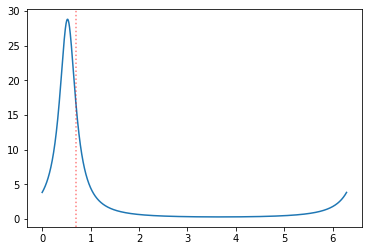

In [15]:
# Improved with correlated sources
n_sources = len(azimuth)
seg_duration = 1.0
freq_range=[0, 250]

spectrum = music_with_frequency(aroom.mic_array.signals, n_sources, fs, mics_coords, segment_duration=seg_duration, freq_range=freq_range,
                                correlated=True)

X = np.linspace(0, 2*np.pi, 2000)
Y = np.array([spectrum(x) for x in X])

plt.plot(X, Y)

for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi]) * 180 / np.pi)

plt.show()

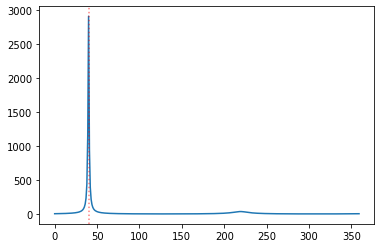

In [16]:
nfft = 1024
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])
doa = pra.doa.algorithms["MUSIC"](mics_coords, fs, nfft, c=c, num_src=2, max_four=4)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values
plt.plot(spatial_resp)

for theta in azimuth:
    plt.axvline(x=theta/np.pi*180, color='red', linestyle=':', alpha=0.5)
